In [1]:
cd ..

/data/2022F/CS330/project


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import itertools

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import model
import utils
import train

## Task Setup
Setup datasets, loss functions, etc.

In [4]:
import transformers
import experiment_lang

device='cuda:1'

bert, tokenizer = experiment_lang.get_model_and_tokenizer('prajjwal1/bert-medium', transformers.AutoModelForSequenceClassification)
stop_tokens = experiment_lang.get_stop_tokens(tokenizer)

def loss_func(logits, labels):
    #print(logits, labels)
    return F.binary_cross_entropy_with_logits(logits, labels[..., None].float())
def get_language_task(name):
    ds_train, ds_val = experiment_lang.get_dataset(name)

    generator_train = experiment_lang.ClassificationDataGenerator(ds_train, tokenizer, device)
    generator_val = experiment_lang.ClassificationDataGenerator(ds_val, tokenizer, device)
    return {
        'train_iter': iter(generator_train),
        'eval_ds': generator_val.get_all(cutoff=100),
        'loss': loss_func, #lambda logits, labels: F.binary_cross_entropy_with_logits(logits, labels[..., None]),
        'predict': lambda logits: torch.sigmoid(logits) > 0.5,
        'metric': lambda yh, y: accuracy(yh, y.long().bool()[..., None]),
    }

tasks = {
    'mrpc': get_language_task('glue/mrpc'),
    'qnli': get_language_task('glue/qnli'),
}
task_keys = list(tasks.keys())


Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

## Compute gradient alignments

In [9]:
modelShared = experiment_lang.TaskAwareBert(bert, list(tasks.keys()), 'shared').to(device)
modelShared = modelShared.train()
print(modelShared.training)

grads = train.get_gradients(
    model=modelShared,
    tasks=tasks, 
    steps=200, 
    lr=3e-4,
    DEVICE=device
)

True


  0%|          | 0/200 [00:00<?, ?it/s]

{}
{}


Losses: 0.8089149594306946.0.614446759223938:   0%|          | 1/200 [00:00<02:13,  1.49it/s]

{}
{}
{}
{}


Losses: 0.7935889959335327.0.7427594661712646:   1%|          | 2/200 [00:01<02:12,  1.49it/s]

{}
{}
{}
{}


Losses: 0.6845611333847046.0.5870670080184937:   2%|▏         | 3/200 [00:02<02:11,  1.50it/s]

{}
{}
{}
{}


Losses: 0.7034046053886414.0.9020310044288635:   2%|▏         | 4/200 [00:02<02:10,  1.50it/s]

{}
{}
{}
{}


Losses: 0.7916069626808167.1.0708646774291992:   2%|▎         | 5/200 [00:03<02:11,  1.49it/s]

{}
{}


Losses: 0.48795169591903687.0.9058704376220703: 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]


In [8]:
modelShared.train()

TaskAwareBert(
  (backbone): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 512, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=512, out_features=512, bias=True)
                (key): Linear(in_features=512, out_features=512, bias=True)
                (value): Linear(in_features=512, out_features=512, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=512, out_features=512, bias=

In [6]:
 list(modelShared.named_parameters()) 

[('backbone.bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0387,  0.0531, -0.0411,  ..., -0.0078,  0.0048,  0.0089],
          [-0.0524,  0.0737, -0.0528,  ..., -0.0074, -0.1095, -0.0535],
          [ 0.0677,  0.0051, -0.0410,  ..., -0.0340,  0.0048,  0.0006],
          ...,
          [ 0.0352, -0.0067,  0.0065,  ...,  0.0094,  0.0247,  0.0347],
          [-0.0492,  0.0187, -0.0098,  ..., -0.0008, -0.0598, -0.0075],
          [ 0.0280, -0.0922,  0.0245,  ..., -0.0625, -0.0159, -0.0210]],
         device='cuda:1', requires_grad=True)),
 ('backbone.bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[-0.0106, -0.0293,  0.0291,  ...,  0.0087, -0.0500, -0.0226],
          [ 0.0027, -0.0165,  0.0114,  ..., -0.0012, -0.0196,  0.0029],
          [-0.0055, -0.0064,  0.0008,  ...,  0.0176, -0.0054,  0.0108],
          ...,
          [-0.0130,  0.0405, -0.0007,  ...,  0.0012,  0.0290,  0.0018],
          [-0.0038,  0.0341,  0.0046,  ...,

In [10]:
grads

[{'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 {'mrpc': {}, 'qnli': {}},
 

['backbone.bert.encoder.layer.0.attention.self.query.weight', 'backbone.bert.encoder.layer.0.attention.self.query.bias', 'backbone.bert.encoder.layer.0.attention.self.key.weight', 'backbone.bert.encoder.layer.0.attention.self.key.bias', 'backbone.bert.encoder.layer.0.attention.self.value.weight', 'backbone.bert.encoder.layer.0.attention.self.value.bias', 'backbone.bert.encoder.layer.0.attention.output.dense.weight', 'backbone.bert.encoder.layer.0.attention.output.dense.bias', 'backbone.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.bert.encoder.layer.0.intermediate.dense.weight', 'backbone.bert.encoder.layer.0.intermediate.dense.bias', 'backbone.bert.encoder.layer.0.output.dense.weight', 'backbone.bert.encoder.layer.0.output.dense.bias', 'backbone.bert.encoder.layer.0.output.LayerNorm.weight', 'backbone.bert.encoder.layer.0.output.LayerNorm.bias', 'backbone.bert.encoder.layer.1.attention.self.query.wei

KeyError: 'backbone.bert.encoder.layer.0.attention.self.query.weight'

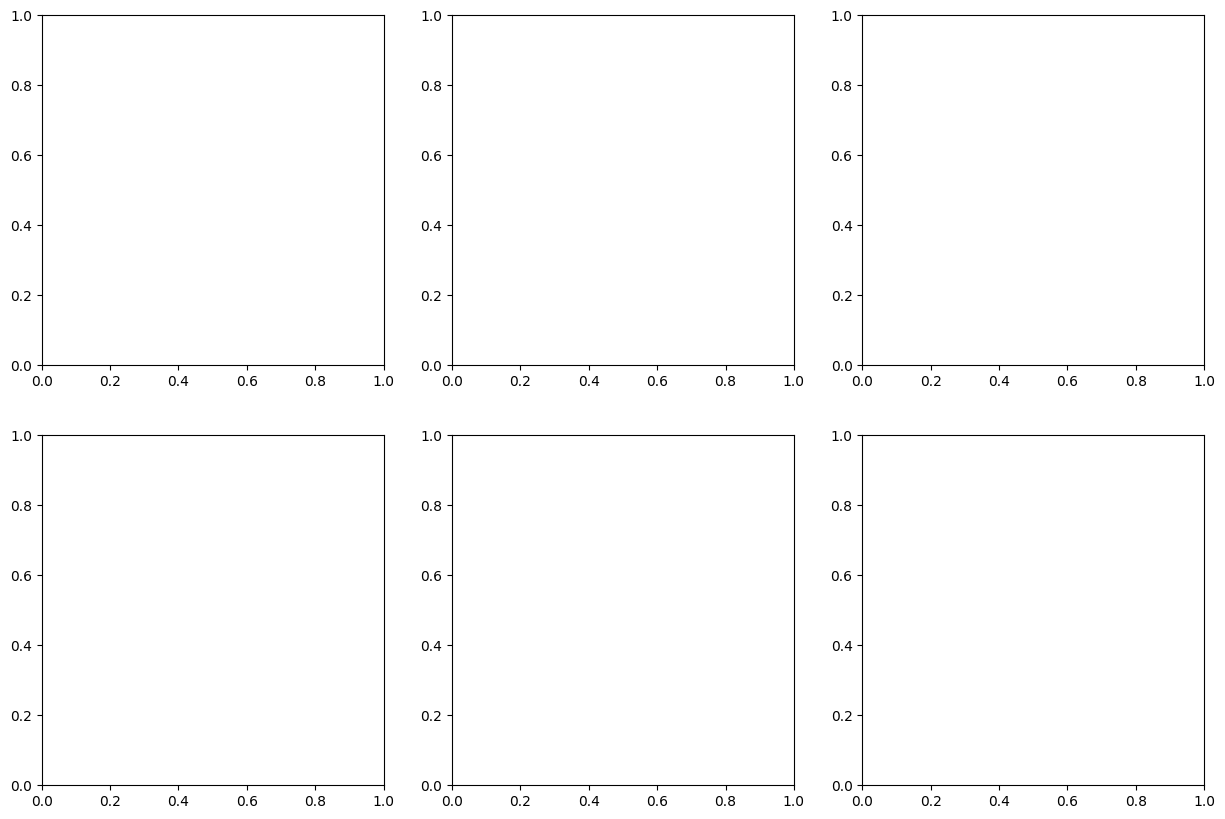

In [7]:
param_keys = ['backbone.' + k for k in modelShared.backbone_trainables]
print(param_keys)

heuristic_results = {}

# plots
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, key in enumerate(param_keys):
    # get gradients
    g0 = utils.stack_grad(grads, task_keys[0], key)
    g1 = utils.stack_grad(grads, task_keys[1], key)
    
    # heuristics computations
    cosine = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    smooth_cos = low_pass_filter(cosine[None], filter_size=10)[0][0]
    
    avg_smoothed_cos = smooth_cos.mean()
    std_cos = cosine.std()
    
    heuristic_results[key] = {'avg_cos': avg_smoothed_cos, 'std_cos': std_cos}
      
    # plot
    row, col = i // n_cols, i % n_cols
    ax = axes[row][col]    
    ax.set_title(key)
    if col == 0:
        ax.set_ylabel('Gradient cosine similarity')
    if row == n_rows - 1:
        ax.set_xlabel('Step')
    ax.set_ylim([-1.1, 1.1])
    ax.plot(cosine, color='teal', alpha=0.2)
    ax.plot(smooth_cos, color='teal')

In [210]:
heuristic_results

{'backbone.net.0.weight': {'avg_cos': 0.055701334, 'std_cos': tensor(0.2127)},
 'backbone.net.0.bias': {'avg_cos': 0.10142583, 'std_cos': tensor(0.3714)},
 'backbone.net.2.weight': {'avg_cos': 0.055880837, 'std_cos': tensor(0.2850)},
 'backbone.net.2.bias': {'avg_cos': 0.07913873, 'std_cos': tensor(0.4363)},
 'backbone.net.4.weight': {'avg_cos': 0.001982077, 'std_cos': tensor(0.1276)},
 'backbone.net.4.bias': {'avg_cos': -0.0012353057, 'std_cos': tensor(0.1840)}}

## Experiments

In [241]:
mtl = SharedMTL(tasks.keys())
fully_shared_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
)


100%|██████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 80.16it/s]


In [242]:
class SeparateMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbones = nn.ModuleDict({
            task: LinearBackbone()
            for task in task_keys
        })
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbones[task](x)) 

mtl = SeparateMTL(tasks.keys())
separate_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
)


100%|██████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 85.96it/s]


In [244]:
class SurgicalMTL(nn.Module):
    def __init__(self, task_keys):
        super().__init__()
        self.backbone = model.Shareable(
            mdl=LinearBackbone(),
            task_keys=list(task_keys),
            shared_params=['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias']
        )
        self.heads = nn.ModuleDict({
            task: nn.Linear(256, 1)
            for task in task_keys
        })
    
    def forward(self, x, task):
        return self.heads[task](self.backbone(x, task))

mtl = SurgicalMTL(tasks.keys())
surgical_exp = train.train_and_evaluate(
    model=mtl,
    tasks=tasks,
    steps=500,
    lr=1e-4,
    eval_every=50,
)



  0%|                                                                    | 0/500 [00:00<?, ?it/s]

  0%|                                                            | 1/500 [00:00<01:23,  5.94it/s]

  3%|█▊                                                         | 15/500 [00:00<00:07, 66.61it/s]

  6%|███▍                                                       | 29/500 [00:00<00:04, 95.28it/s]

  9%|█████                                                     | 44/500 [00:00<00:04, 112.40it/s]

 11%|██████▋                                                    | 57/500 [00:00<00:05, 76.55it/s]

 14%|████████▍                                                  | 72/500 [00:00<00:04, 92.42it/s]

 17%|█████████▉                                                | 86/500 [00:00<00:03, 104.21it/s]

 20%|███████████▍                                             | 100/500 [00:01<00:03, 113.17it/s]

 23%|█████████████                                             | 113/500 [00:01<00:04, 84.28it/s]

 26%|███

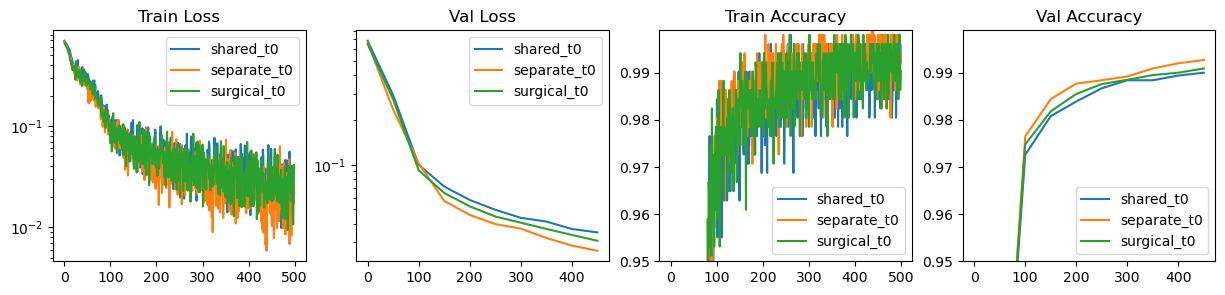

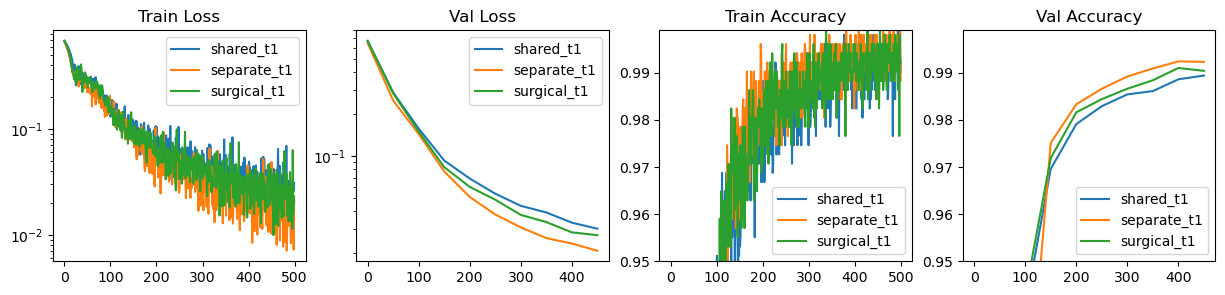

In [249]:
for task_name in tasks:
    fig, axes = plt.subplots(1, 4, figsize=(15, 3))

    for exp_name, exp in [
        ('shared', fully_shared_exp),
        ('separate', separate_exp),
        ('surgical', surgical_exp),
    ]:
        losses, metrics, eval_losses, eval_metrics = exp
        
        tl = [(s, l[task_name]) for s, l in losses]
        el = [(s, l[task_name]) for s, l in eval_losses]
        tm = [(s, m[task_name]) for s, m in metrics]
        em = [(s, m[task_name]) for s, m in eval_metrics]
    
        # plot
        ax = axes[0]
        tl_x, tl_y = zip(*tl)
        ax.plot(tl_x, tl_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Loss')
        ax.set_yscale('log')
        ax.legend()

        ax = axes[1]
        el_x, el_y = zip(*el)
        ax.plot(el_x, el_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Loss')
        ax.set_yscale('log')
        ax.legend()

        ax = axes[2]
        tm_x, tm_y = zip(*tm)
        ax.plot(tm_x, tm_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Train Accuracy')
        ax.set_ylim([0.95, 0.999])
        ax.legend()

        ax = axes[3]
        em_x, em_y = zip(*em)
        ax.plot(em_x, em_y, label=f'{exp_name}_{task_name}')
        ax.set_title('Val Accuracy')
        ax.set_ylim([0.95, 0.999])
        ax.legend()